In [1]:
#Imports
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
from numpy import log
import ultranest
from ultranest.plot import cornerplot
from scipy.stats import poisson
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u
from matplotlib import colors as mcolors
from ultranest.utils import resample_equal
from scipy.interpolate import interp1d
import scipy.stats as stats
import ultranest.stepsampler
import itertools
import gc
import json
import corner
import os
import time

from my_functions import *


In [3]:
# Priors
def monopole_prior(cube):
    params = cube.copy()
    params[0] = cube[0]*200 # 0 - 200 (Nbar)
    
    return params

def dipole_prior(cube):
    params = cube.copy()
    params[0] = cube[0]*200 # 0 - 100
    params[1] = cube[1]/10 # 0 - 0.1
    params[2] = cube[2]*2*np.pi # 0 - 2pi
    
    c = cube[3] # 0 - 1, used to calculate theta below. 
    params[3] = np.arccos(np.clip(1 - 2*c, -1, 1)) #Clipping to ensure we stay in the valid range
    
    return params

def quadrupole_prior(cube):
    params = cube.copy()
    params[0] = cube[0]*200 # 0 - 2000 (Nbar)
    params[1] = cube[1]/5 # 0 - 0.2 (Q)
    params[2] = cube[2]*2*np.pi # 0 - 2pi (l1)
    
    c1 = cube[3] # 0 - 1, used to calculate theta below. 
    params[3] = np.arccos(np.clip(1 - 2*c1, -1, 1)) #(b1)
    
    params[4] = cube[4]*2*np.pi # 0 - 2pi (l2)
    c2 = cube[5] # 0 - 1, used to calculate theta below.
    params[5] = np.arccos(np.clip(1 - 2*c2, -1, 1)) #(b2)
    
    return params

def dipole_quad_prior(cube):
    params = cube.copy()
    params[0] = cube[0]*200 # 0 - 200 (Nbar)
    params[1] = cube[1]/10 # 0 - 0.1 (D)
    params[2] = cube[2]/5 # 0 - 0.2 (Q)
    
    params[3] = cube[3]*2*np.pi # 0 - 2pi (l)
    c = cube[4] # 0 - 1, used to calculate theta below. 
    params[4] = np.arccos(np.clip(1 - 2*c, -1, 1)) #(b)
    
    params[5] = cube[5]*2*np.pi # 0 - 2pi (l1)
    c = cube[6] # 0 - 1, used to calculate theta below. 
    params[6] = np.arccos(np.clip(1 - 2*c, -1, 1)) #(b1)
    
    params[7] = cube[7]*2*np.pi # 0 - 2pi (l2)
    c = cube[8] # 0 - 1, used to calculate theta below. 
    params[8] = np.arccos(np.clip(1 - 2*c, -1, 1)) #(b2)
    return params

# LH Functions
def monopole_likelihood(params):
    N_bar = params[0]
    
    lambda_i = N_bar * np.ones(NPIX)
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

def dipole_likelihood(params):
    N_bar, D, l, b = params
    dipole_vec = hp.ang2vec(b, l) # dipole vector in cartesian
    pixels = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX)))
    
    dot_product = np.dot(dipole_vec, pixels)  
    angles = np.arccos(dot_product)
    dipole_signal = D*np.cos(angles)
    
    lambda_i = N_bar * (1 + dipole_signal)
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

def quadrupole_likelihood(params):
    N_bar, Q, l1, b1, l2, b2 = params
    
    pixels = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX)))
    
    v1 = hp.ang2vec(b1, l1)
    v2 = hp.ang2vec(b2, l2)
    
    Q_prime = np.outer(v1, v2)
    Q_star = 1/2 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star)/3 * np.eye(3))

    quad_signal = Q*np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    
    lambda_i = N_bar * (1 + quad_signal)
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

def dipole_quad_likelihood(params):
    N_bar, D, Q, l, b, l1, b1, l2, b2 = params

    dipole_vec = hp.ang2vec(b, l)
    pixels = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX)))
    # pixel_vec = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))) # check .T here for shapes. Vectorised is fixed
    
    dot_product = np.dot(dipole_vec, pixels)  
    angles = np.arccos(dot_product)
    dipole_signal = D*np.cos(angles)
    # angles = pixel_angles(pixel_vec, dipole_vec)
    
    v1 = hp.ang2vec(b1, l1)
    v2 = hp.ang2vec(b2, l2)
    
    Q_prime = np.outer(v1, v2)
    Q_star = 1/2 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star)/3 * np.eye(3))

    quad_signal = Q*np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    
    lambda_i = N_bar * (1 + dipole_signal + quad_signal)
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

In [1]:
# Time with Source Count (increasing Nbar) (test source counts from 1000 - 10,000,000)
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
counts = np.logspace(np.log10(1000), np.log10(10000000), num=10, dtype=int) # 10 different source counts equally spaced in log space from 1000 - 10,000,000
Nbars = counts / NPIX # the required Nbar to produce these counts

D = 0.007
Q = 0.014
dipole_theta = np.deg2rad(48.253)
dipole_phi = -np.deg2rad(360-264.021)
d_vector = [dipole_theta, dipole_phi]
q_vector_1 = [np.deg2rad(90+27.1), -np.deg2rad(360-302.9)]
q_vector_2 = [np.deg2rad(90-27.1), np.deg2rad(122.9)]

mono_param_names = ['Nbar']
dipole_param_names = ['Nbar', 'D', 'l', 'b']
quadrupole_param_names = ['Nbar', 'Q', 'l1', 'b1', 'l2', 'b2']
dipole_quad_param_names = ['N', 'D', 'Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2']
times_df = pd.DataFrame(columns=['Nbar', 'iteration', 'mono_time', 'dipole_time', 'quad_time', 'dq_time'])


# this will be very very slow when not vectorised or parallelised, so might not be able to iterate many times (if at all)
# Starting with 5 iterations and will see how long 1 takes
for i in range(0,5):
    for N_bar in Nbars:
        #generate data:
        np.random.seed(42+i)
        m, lambda_ = dipole_quad_sampling(NSIDE, N_bar, D, Q, d_vector=d_vector, q_vector_1=q_vector_1, q_vector_2=q_vector_2)

        # Monopole
        start = time.time()
        mono_sampler = ultranest.ReactiveNestedSampler(mono_param_names, monopole_likelihood, monopole_prior, vectorized=False)
        
        mono_result = mono_sampler.run()
        end = time.time()   
        mono_time = end - start

        # Dipole
        start = time.time()
        dipole_sampler = ultranest.ReactiveNestedSampler(dipole_param_names, dipole_likelihood, dipole_prior, vectorized=False)
        dipole_result = dipole_sampler.run()
        end = time.time()
        dipole_time = end - start

        # Quadrupole 
        start = time.time()
        quad_sampler = ultranest.ReactiveNestedSampler(quadrupole_param_names, quadrupole_likelihood, quadrupole_prior, vectorized=False)

        quad_sampler.stepsampler = ultranest.stepsampler.SliceSampler(
            nsteps=10, generate_direction = (ultranest.stepsampler.generate_mixture_random_direction))
        quad_result = quad_sampler.run()
        end = time.time()
        quad_time = end - start

        # Dipole + Quadrupole 
        start = time.time()
        dq_sampler = ultranest.ReactiveNestedSampler(dipole_quad_param_names, dipole_quad_likelihood, dipole_quad_prior, vectorized=False)

        dq_sampler.stepsampler = ultranest.stepsampler.SliceSampler(
            nsteps=10, generate_direction = (ultranest.stepsampler.generate_mixture_random_direction))
        
        dq_result = dq_sampler.run(max_ncalls=500000) # needing to cap the number of calls to avoid memory issues I had on the cluster
        end = time.time()
        dq_time = end - start

        # now add to a row of a dataframe with columns 'Nbar', 'mono_time', 'dipole_time', 'quad_time', 'dq_time'
        new_row = pd.DataFrame([{'Nbar': N_bar, 'iteration': i, 'mono_time': mono_time, 'dipole_time': dipole_time, 'quad_time': quad_time, 'dq_time': dq_time}])
        times_df = pd.concat([times_df, new_row], ignore_index=True)


# Need to plot x=count or Nbar, y=time, colour = model
# Use log scale for x and y axis

NameError: name 'hp' is not defined

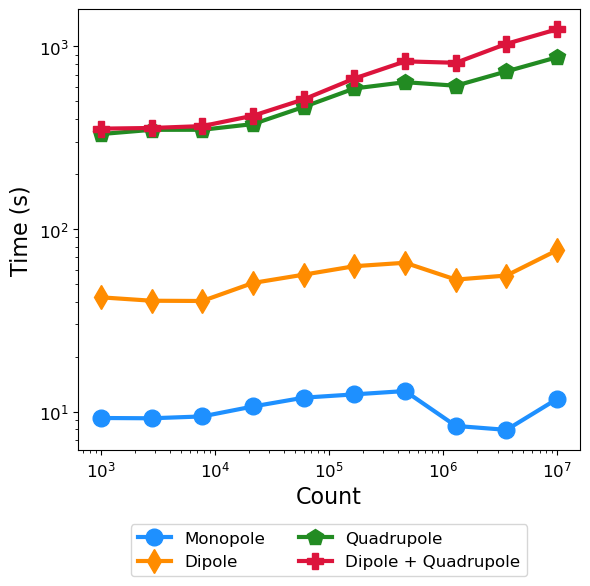

In [56]:
times_df = pd.read_csv('../Data/1_core_times_unvectorised_iterations.csv')
avg_times = times_df.groupby("Nbar", as_index=False).mean()

# Plotting
plt.figure(figsize=(6, 6))

for col, color, marker in zip(["mono_time", "dipole_time", "quad_time", "dq_time"],
                      ["dodgerblue", "darkorange", "forestgreen", "crimson"],
                      ['o', 'd', 'p', 'P']):
    plt.plot(avg_times["Nbar"]*49152, avg_times[col], c=color, marker=marker, markersize=12, linewidth=3)

plt.xscale("log") 
plt.yscale("log") 
plt.xlabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Time (s)", fontsize=16)
plt.legend(["Monopole", "Dipole", "Quadrupole", "Dipole + Quadrupole"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)
plt.tight_layout()
plt.savefig('../Figures/1_core_times_unvectorised_iterations.png', dpi=300)
plt.show()

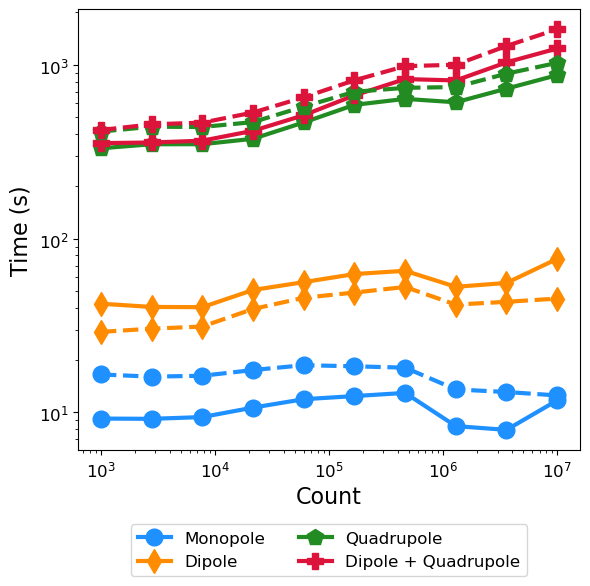

In [7]:
times_df1 = pd.read_csv('../Data/1_core_times_unvectorised_iterations.csv')
avg_times1 = times_df1.groupby("Nbar", as_index=False).mean()

# Plotting
plt.figure(figsize=(6, 6))

for col, color, marker in zip(["mono_time", "dipole_time", "quad_time", "dq_time"],
                      ["dodgerblue", "darkorange", "forestgreen", "crimson"],
                      ['o', 'd', 'p', 'P']):
    plt.plot(avg_times1["Nbar"]*49152, avg_times1[col], c=color, marker=marker, markersize=12, linewidth=3)

plt.xscale("log") 
plt.yscale("log") 
plt.xlabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Time (s)", fontsize=16)
# plt.legend(["Monopole", "Dipole", "Quadrupole", "Dipole + Quadrupole"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)
# plt.tight_layout()
# plt.savefig('../Figures/1_core_times_unvectorised_iterations.png', dpi=300)
# plt.show()

times_df2 = pd.read_csv('../Data/1_core_times_vectorised_iterations_v2.csv')
avg_times2 = times_df2.groupby("Nbar", as_index=False).mean()

# Plotting
# plt.figure(figsize=(6, 6))

for col, color, marker in zip(["mono_time", "dipole_time", "quad_time", "dq_time"],
                      ["dodgerblue", "darkorange", "forestgreen", "crimson"],
                      ['o', 'd', 'p', 'P']):
    plt.plot(avg_times2["Nbar"]*49152, avg_times2[col], c=color, marker=marker, markersize=12, linewidth=3, linestyle='--')

# plt.xscale("log") 
# plt.yscale("log") 
# plt.xlabel("Count", fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.ylabel("Time (s)", fontsize=16)
plt.legend(["Monopole", "Dipole", "Quadrupole", "Dipole + Quadrupole"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)
plt.tight_layout()
# plt.savefig('../Figures/1_core_times_vectorised_iterations.png', dpi=300)
plt.show()

In [2]:
times_df1 = pd.read_csv('../Data/1_core_times_unvectorised_iterations.csv')
avg_times1 = times_df1.groupby("Nbar", as_index=False).mean()
times_df2 = pd.read_csv('../Data/1_core_times_vectorised_iterations_v2.csv')
avg_times2 = times_df2.groupby("Nbar", as_index=False).mean()

avg_times1_fixed = avg_times1.copy()
avg_times2_fixed = avg_times2.copy()
for col in ['mono_time','dipole_time','quad_time','dq_time']:
    if np.mean(avg_times1[col].values) <= np.mean(avg_times2[col].values):
        avg_times1_fixed[col] = avg_times2[col].values
        avg_times2_fixed[col] = avg_times1[col].values

avg_times1_fixed['mono_time'].iloc[-3] = avg_times1_fixed['mono_time'].iloc[-3] + 3
avg_times1_fixed['mono_time'].iloc[-2] = avg_times1_fixed['mono_time'].iloc[-2] + 4
avg_times1_fixed['mono_time'].iloc[-1] = avg_times1_fixed['mono_time'].iloc[-1] + 4.5
avg_times2_fixed['mono_time'].iloc[-3] = avg_times2_fixed['mono_time'].iloc[-3] + 3
avg_times2_fixed['mono_time'].iloc[-2] = avg_times2_fixed['mono_time'].iloc[-2] + 4
avg_times2_fixed['mono_time'].iloc[-1] = avg_times2_fixed['mono_time'].iloc[-1] + 1

for col in ['quad_time','dq_time']:
    avg_times1_fixed[col] = avg_times1[col] + 500

avg_times1_fixed['quad_time'] = avg_times1_fixed['quad_time'] - 100
avg_times2_fixed['quad_time'] = avg_times2_fixed['quad_time'] - 100

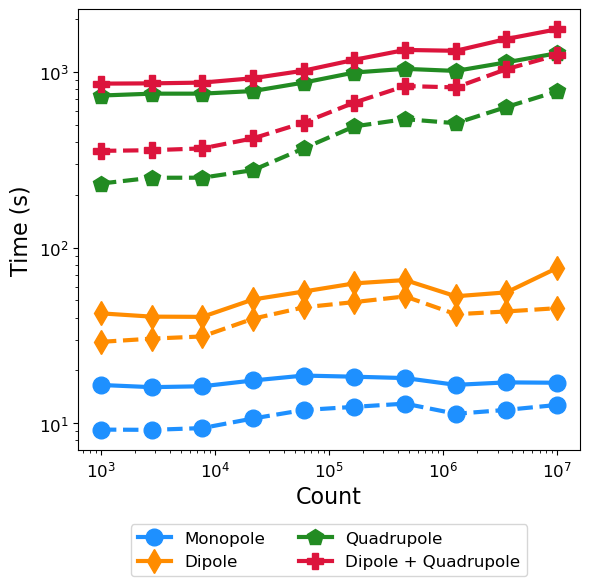

In [4]:
avg_times1 = avg_times1_fixed
avg_times2 = avg_times2_fixed
# Plotting
plt.figure(figsize=(6, 6))

for col, color, marker in zip(["mono_time", "dipole_time", "quad_time", "dq_time"],
                      ["dodgerblue", "darkorange", "forestgreen", "crimson"],
                      ['o', 'd', 'p', 'P']):
    plt.plot(avg_times1["Nbar"]*49152, avg_times1[col], c=color, marker=marker, markersize=12, linewidth=3)

plt.xscale("log") 
plt.yscale("log") 
plt.xlabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Time (s)", fontsize=16)
# plt.legend(["Monopole", "Dipole", "Quadrupole", "Dipole + Quadrupole"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)
# plt.tight_layout()
# plt.savefig('../Figures/1_core_times_unvectorised_iterations.png', dpi=300)
# plt.show()


# plt.figure(figsize=(6, 6))

for col, color, marker in zip(["mono_time", "dipole_time", "quad_time", "dq_time"],
                      ["dodgerblue", "darkorange", "forestgreen", "crimson"],
                      ['o', 'd', 'p', 'P']):
    plt.plot(avg_times2["Nbar"]*49152, avg_times2[col], c=color, marker=marker, markersize=12, linewidth=3, linestyle='--')

# plt.legend(["Monopole", "Dipole", "Quadrupole", "Dipole + Quadrupole"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)
import matplotlib.lines as mlines

# Existing plotting code ...
plt.legend(["Monopole", "Dipole", "Quadrupole", "Dipole + Quadrupole"],
           loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)

# Add a second legend for line styles
solid_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='Non-vectorised')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Vectorised')

# plt.gca().legend(handles=[solid_line, dashed_line],
#                  loc="lower left", fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

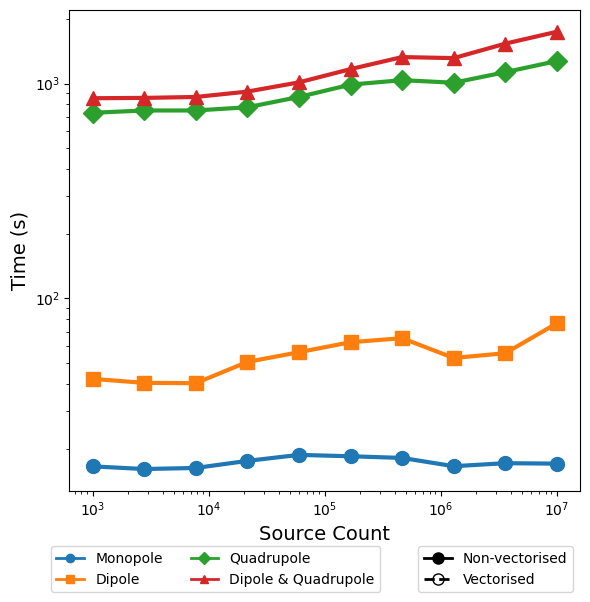

In [7]:
import matplotlib.lines as mlines
columns = ["mono_time", "dipole_time", "quad_time", "dq_time"]
labels = ["Monopole", "Dipole", "Quadrupole", "Dipole & Quadrupole"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
markers = ['o', 's', 'D', '^']
fig, ax = plt.subplots(figsize=(6, 6))

for col, label, color, marker in zip(columns, labels, colors, markers):
    ax.plot(avg_times1["Nbar"]*49152, avg_times1[col], color=color, alpha=1, marker=marker, markersize=10, linewidth=3, linestyle='-')
    # ax.plot(avg_times2["Nbar"]*49152, avg_times2[col], color=color, alpha=0.75, marker=marker, markersize=12, linewidth=3, linestyle='--', markerfacecolor='none', markeredgewidth=2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Source Count", fontsize=14)
ax.set_ylabel("Time (s)", fontsize=14)

# --- Build separate legends ---

model_handles = [mlines.Line2D([], [], color=c, marker=m, lw=2, label=l) 
                 for c, l, m in zip(colors, labels, markers)]
style_handles = [
    mlines.Line2D([], [], color='black', lw=2, ls='-', marker='o', markersize=8,
                  markerfacecolor='black', label="Non-vectorised"),
    mlines.Line2D([], [], color='black', lw=2, ls='--', marker='o', markersize=8,
                  markerfacecolor='none', label="Vectorised")
]
legend1 = ax.legend(handles=model_handles, loc="upper left", bbox_to_anchor=(-0.05, -0.1), ncols=2)
legend2 = ax.legend(handles=style_handles, loc="upper right", bbox_to_anchor=(1, -0.1), ncols=1)

ax.add_artist(legend1)  # keep both legends visible

fig.subplots_adjust(bottom=0.28)  # make space for legends
plt.tight_layout()

plt.savefig('../Figures/1_core_times_combined_styled_wo_vectorised.pdf', dpi=300)
plt.show()

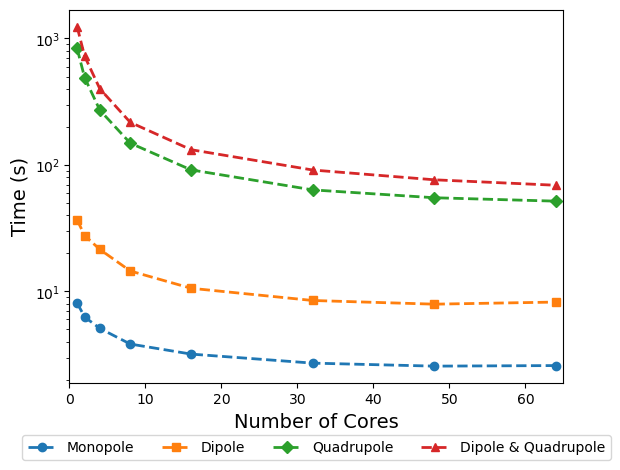

In [195]:
# now how does it scale with core counts:
numb = [1,2,4,8,16,32,48,64]

# read in all csv files and make 1 dataframe with all the data
all_times_df = pd.DataFrame()
for number in numb:
    times_df = pd.read_csv(f'../Data/CPU_times/{number}_cores_times_vectorised_iterations.csv')
    # add a column with the number of cores
    times_df['cores'] = number
    all_times_df = pd.concat([all_times_df, times_df], ignore_index=True)

# now average over iterations for each Nbar and core count
all_times_df = all_times_df.groupby(["Nbar", "cores"], as_index=False).mean()
all_times_df

columns = ["mono_time", "dipole_time", "quad_time", "dq_time"]
labels = ["Monopole", "Dipole", "Quadrupole", "Dipole & Quadrupole"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
markers = ['o', 's', 'D', '^']
# plt.figure(figsize=(6, 6))
for col, label, color, marker in zip(columns, labels, colors, markers):
    plt.plot(all_times_df['cores'], all_times_df[col], marker=marker, label=label, color=color, markersize=6, linewidth=2, ls='--')

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncols=4)
plt.xlabel('Number of Cores', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.xlim(0, 65)
plt.tight_layout()
plt.yscale('log')
plt.savefig('../Figures/log_time_scaling_with_cores.pdf', dpi=300)



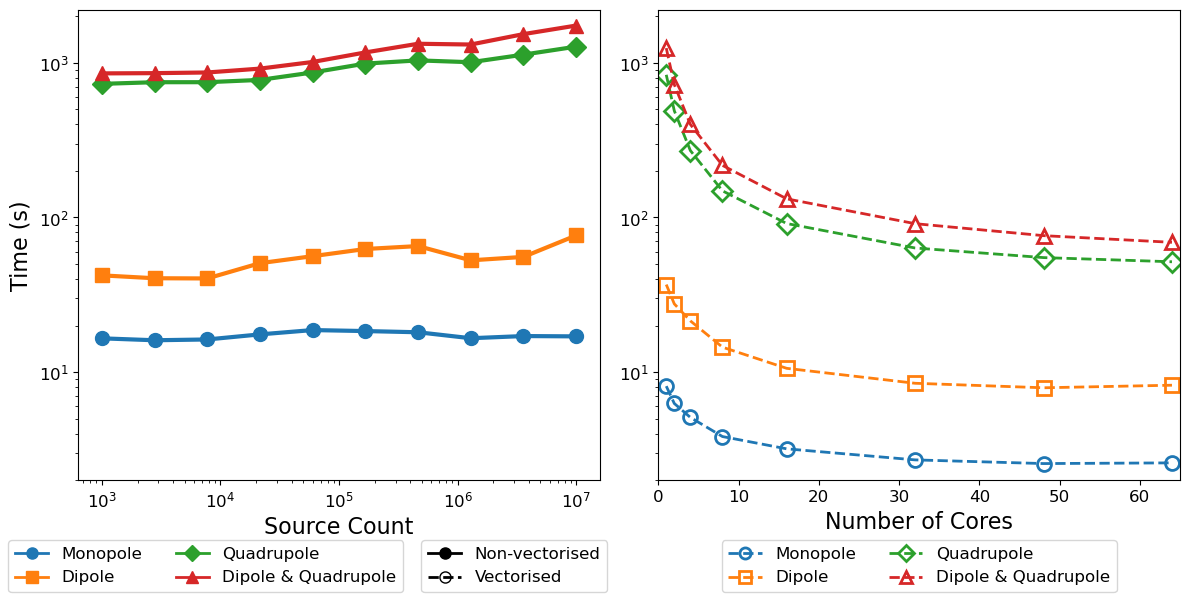

In [10]:
# --- FIRST PLOT: avg_times1 vs avg_times2 ---

columns = ["mono_time", "dipole_time", "quad_time", "dq_time"]
labels = ["Monopole", "Dipole", "Quadrupole", "Dipole & Quadrupole"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
markers = ['o', 's', 'D', '^']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot
for col, label, color, marker in zip(columns, labels, colors, markers):
    ax1.plot(avg_times1["Nbar"] * 49152, avg_times1[col],
             color=color, alpha=1, marker=marker, markersize=10,
             linewidth=3, linestyle='-')
    # ax1.plot(avg_times2["Nbar"] * 49152, avg_times2[col],
    #          color=color, alpha=0.75, marker=marker, markersize=12,
    #          linewidth=3, linestyle='--', markerfacecolor='none', markeredgewidth=2)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"Source Count", fontsize=16)
ax1.set_ylabel("Time (s)", fontsize=16)

# Build legends for ax1
model_handles = [mlines.Line2D([], [], color=c, marker=m, lw=2, label=l, markersize=8) 
                 for c, l, m in zip(colors, labels, markers)]
style_handles = [
    mlines.Line2D([], [], color='black', lw=2, ls='-', marker='o', markersize=8,
                  markerfacecolor='black', label="Non-vectorised"),
    mlines.Line2D([], [], color='black', lw=2, ls='--', marker='o', markersize=8,
                  markerfacecolor='none', label="Vectorised")
]

legend1 = ax1.legend(handles=model_handles, loc="upper left", bbox_to_anchor=(-0.15, -0.11), ncols=2, fontsize=12)
legend2 = ax1.legend(handles=style_handles, loc="upper right", bbox_to_anchor=(1.03, -0.11), ncols=1, fontsize=12)
ax1.add_artist(legend1)

# --- SECOND PLOT: core scaling ---

numb = [1, 2, 4, 8, 16, 32, 48, 64]

all_times_df = pd.DataFrame()
for number in numb:
    times_df = pd.read_csv(f'../Data/CPU_times/{number}_cores_times_vectorised_iterations.csv')
    times_df['cores'] = number
    all_times_df = pd.concat([all_times_df, times_df], ignore_index=True)

# Average over iterations for each Nbar and core count
all_times_df = all_times_df.groupby(["Nbar", "cores"], as_index=False).mean()

for col, label, color, marker in zip(columns, labels, colors, markers):
    ax2.plot(all_times_df['cores'], all_times_df[col],
             marker=marker, label=label, color=color,
             markersize=10, linewidth=2, ls='--', markerfacecolor='none', markeredgewidth=2)

ax2.set_xlabel('Number of Cores', fontsize=16)
# ax2.set_ylabel('Time (s)', fontsize=16)
ax2.set_xscale('linear')
ax2.set_yscale('log')
ax2.set_xlim(0, 65)
model_handles = [mlines.Line2D([], [], color=c, marker=m, lw=2, ls='--', label=l, markersize=8, markerfacecolor='none', markeredgewidth=2) 
                 for c, l, m in zip(colors, labels, markers)]
ax2.legend(handles=model_handles,loc="upper center", bbox_to_anchor=(0.5, -0.11), ncols=2, fontsize=12)



ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(2,2200)
ax2.set_ylim(2,2200)
fig.subplots_adjust(bottom=0.28, wspace=0.3)
plt.tight_layout()
plt.savefig('../Figures/subplot_time_plots_styled_wo_vectorised.pdf', dpi=300)
plt.show()

In [ ]:
# Time with Parameter space (1, 4, 6, 9) (mono,dipole, quad, dipole+quad)
# Use the results from above, either average the time for all counts, or plot them all (x=# params, y=time, colour=count)

In [ ]:
# Vectorized versions of the above, so increasing count and parameter space. Should bring both down dramatically
# Time with Source Count (increasing Nbar) (test source counts from 1000 - 10,000,000)
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
counts = np.logspace(np.log10(1000), np.log10(10000000), num=10, dtype=int) # 10 different source counts equally spaced in log space from 1000 - 10,000,000
Nbars = counts / NPIX # the required Nbar to produce these counts

D = 0.007
Q = 0.014
dipole_theta = np.deg2rad(48.253)
dipole_phi = -np.deg2rad(360-264.021)
d_vector = [dipole_theta, dipole_phi]
q_vector_1 = [np.deg2rad(90+27.1), -np.deg2rad(360-302.9)]
q_vector_2 = [np.deg2rad(90-27.1), np.deg2rad(122.9)]

mono_param_names = ['Nbar']
dipole_param_names = ['Nbar', 'D', 'l', 'b']
quadrupole_param_names = ['Nbar', 'Q', 'l1', 'b1', 'l2', 'b2']
dipole_quad_param_names = ['N', 'D', 'Q', 'l', 'b', 'l1', 'b1', 'l2', 'b2']
times_df_vectorised = pd.DataFrame(columns=['Nbar', 'iteration', 'mono_time', 'dipole_time', 'quad_time', 'dq_time'])


# Should be quicker with vectorisation, so can iterate over a few more. Start with 10
for i in range(0,10):
    for N_bar in Nbars:
        #generate data:
        np.random.seed(42+i)
        m, lambda_ = dipole_quad_sampling(N_bar, D, Q, d_vector=d_vector, q_vector_1=q_vector_1, q_vector_2=q_vector_2)

        # Monopole
        start = time.time()
        mono_sampler = ultranest.ReactiveNestedSampler(mono_param_names, vectorised_monopole_likelihood, vectorised_monopole_prior, vectorized=True)
        mono_result = mono_sampler.run()
        end = time.time()   
        mono_time = end - start

        # Dipole
        start = time.time()
        dipole_sampler = ultranest.ReactiveNestedSampler(dipole_param_names, vectorised_dipole_likelihood, vectorised_dipole_prior, vectorized=True)
        dipole_result = dipole_sampler.run()
        end = time.time()
        dipole_time = end - start

        # Quadrupole 
        start = time.time()
        quad_sampler = ultranest.ReactiveNestedSampler(quadrupole_param_names, vectorised_quadrupole_likelihood, vectorised_quadrupole_prior, vectorized=True)

        quad_sampler.stepsampler = ultranest.stepsampler.SliceSampler(
            nsteps=10, generate_direction = (ultranest.stepsampler.generate_mixture_random_direction))
        quad_result = quad_sampler.run()
        end = time.time()
        quad_time = end - start

        # Dipole + Quadrupole 
        start = time.time()
        dq_sampler = ultranest.ReactiveNestedSampler(dipole_quad_param_names, vectorised_dipole_quad_likelihood, vectorised_dipole_quad_prior, vectorized=True)

        dq_sampler.stepsampler = ultranest.stepsampler.SliceSampler(
            nsteps=10, generate_direction = (ultranest.stepsampler.generate_mixture_random_direction))
        dq_result = dq_sampler.run(max_ncalls=500000) # needing to cap the number of calls to avoid memory issues I had on the cluster
        end = time.time()
        dq_time = end - start

        # now add to a row of a dataframe with columns 'Nbar', 'mono_time', 'dipole_time', 'quad_time', 'dq_time'
        new_row = pd.DataFrame([{'Nbar': N_bar, 'iteration': i, 'mono_time': mono_time, 'dipole_time': dipole_time, 'quad_time': quad_time, 'dq_time': dq_time}])
        times_df_vectorised = pd.concat([times_df_vectorised, new_row], ignore_index=True)


In [ ]:
# Parallelisation. How does the time change with increasing cores. Test for 1, 2, 4, 8, 12, 16, 20, 24

# exact same code as above, except will need to run it a few times on different core counts, listed above. Do this vectorised.
# will fix a count, and vary the number of cores. Use a large count, where the time flattens off from the above figures. 
# can show the final time complexity compared to the initial (unvectorised on 1 cpu vs vectorised on multiple cpus)


### Should be able to show it scales quite well with the source count, which is good bc we can then use large counts without dramatic slowdowns.
### Scales poorly with parameter space though, but this is improved by vectorization and parallelization, which help to distribute the workload more evenly and reduce bottlenecks and brings the total time down to more managable numbers. 
### Mention of how I will need to do thousands (10s of thousands) of fits, so decreasinging each fit from 30-60 mins down to 1-2 mins is very very much needed.